In [1]:
from common.np import *  # import numpy as np (or import cupy as np)
from common.layers import *
from common.functions import sigmoid

### RNN 순전파

- $h_t = tanh(h_{t-1}W_h + x_{t}W_{x} + b)$

- 형상 확인

![asdf](img/01.png)

### RNN 계산 그래프

![asdf](img/03.png)

### RNN 클래스 구현

In [2]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b  # h_t-1 W_h + x_t W_x + b 연산
        h_next = np.tanh(t)  # tanh 연산

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)  # tanh 미분 : 1 - tanh^2(x)
        db = np.sum(dt, axis=0)  # repeat 노드여서 미분하면 sum노드, 행단위로 합함
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev  # dx의 역할 궁금

#### Time RNN
- RNN 계층을 T개 연결한 신경망
- RNN 계층의 은닉 상태h를 다음 블록에 인계하는 기능 존재 => 케라스에도 initial_state 같은걸로 설정 가능한걸로 기억
- 순전파시 값이 분기되었기 때문에 역전파시 $(dh_t + dh_next)$가 입력값으로 사용됨

![asdf](img/04.png)
![asdf](img/05.png)

In [3]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None  # RNN을 리스트로 저장할 것

        self.h, self.dh = None, None  # 순전파시 마지막 RNN의 은닉상채 저장, 역전파시 앞 블록의 은닉상태의 기울기 저장
        self.stateful = stateful

    def forward(self, xs):  # xs의 형상 = (미니배치 N, 시계열데이터 T, 입력벡터차원 D)
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:  # h를 0으로 초기화
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):  # 시계열 데이터 개수만큼 순회
            layer = RNN(*self.params)  # RNN 계층 생성, *self.params로 가변인자 전달
            self.h = layer.forward(xs[:, t, :], self.h)  # 자기 계층에서 처리할 입력 데이터와 은닉값 h를 전달하여 RNN의 순전파 진행
            hs[:, t, :] = self.h  # 전체 은닉값 hs의 해당 행에 순전파가 진행된 h값 저장
            self.layers.append(layer)  # 레이어에 추가

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):  # 시계열 데이터 개수인데, 역전파라서 반대층부터 역전파
            layer = self.layers[t]  # RNN 계층 꺼내옴
            dx, dh = layer.backward(dhs[:, t, :] + dh)  # RNN 역전파해서 dx와 dh 구함
            dxs[:, t, :] = dx  # dx 저장

            for i, grad in enumerate(layer.grads):  # dWx, dWh, db 값을 각각 합함, p.220 RNN 계층들이 같은 가중치 써서 더한다? 이해 필요
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):  # 은닉값 h 세팅
        self.h = h

    def reset_state(self):
        self.h = None

### RNNLM (Language Model)
- 첫번째 층에 Embedding 레이어를 쌓음 => 단어 ID를 단어벡터로 변환
- 단어의 분산 표현이 RNN 레이어로 입력
- 은닉상태를 다음 레이어로 출력하며 다음 RNN으로 출력
- RNN의 상위에는 Affine과 Softmax 레이어가 존재
- Softmax는 뭐다? 제일 높은거 뽑겠지 뭐... => 다음에 나올 단어 예측 모델, 그래서 LM이라고 하나봄
- 각 RNN 레이어는 은닉값 h가 전달되기 때문에 context를 기억한다고 볼 수 있음

![asdf](img/06.png)

![asdf](img/07.png)

### Time 계층 구현
- Time Embedding, Time Affine 구현
- T개의 계층을 준비해서 시계열로 처리하면 됨

![asdf](img/08.png)

![asdf](img/09.png)

### Time Softmax with Loss
- Cross Entropy 같이 구현
- $x_0$, $x_1$는 Affine 계층을 타고 나온 값
- $t_0$, $t_1$는 정답 레이블 (다음에 나올 단어)
- 시계열 데이터 T개에 대해 Softmax with Loss를 구하고 각 손실을 합하여 평균을 구한 값을 최종 손실로 사용

$L = \frac{1}{T}(L_0 + L_1 + ... + L_{T-1})$

- 미니배치를 적용했기 때문에 N개의 미니배치를 사용하면 N개의 손실을 더해 다시 N으로 나눠 각 데이터의 평균을 구함

![asdf](img/10.png)

### Time Embedding 구현

In [ ]:
class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape

        out = np.empty((N, T, D), dtype='f')
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None

### Time Affine 구현

In [ ]:
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params

        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx

### Time Softmax with Loss

In [ ]:
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 정답 레이블이 원핫 벡터인 경우
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        # 배치용과 시계열용을 정리(reshape)
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_label에 해당하는 데이터는 손실을 0으로 설정
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_labelㅇㅔ 해당하는 데이터는 기울기를 0으로 설정

        dx = dx.reshape((N, T, V))

        return dx

### RNNLM 구현

![asdf](img/11.png)

In [ ]:
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *

In [ ]:
class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화, 가중치의 
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')  # Xavier 초깃값 사용, 노드가 n개라면 표준편차가 1/sqrt(n) 분포로 초기화, p.228
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')  # Xavier 초깃값 사용, 노드가 n개라면 표준편차가 1/sqrt(n) 분포로 초기화, p.228
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')  # Xavier 초깃값 사용, 노드가 n개라면 표준편차가 1/sqrt(n) 분포로 초기화, p.228
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),  # stateful을 True로 해서 이후 RNN 레이어에 은닉값 h 전달됨, 처음은 안댐
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()


### 언어 모델의 평가
- 언어모델 : 주어진 정보 -> 다음에 출현할 단어의 확률분포 출력
- 언어 모델의 예측 성능을 평가하는 척도로 `perplexity(혼란도)`를 자주 사용
    - 모델 1 : 'you' 라는 단어에 대해 `say`의 확률이 0.8로 나오면 perplexity는 $\frac{1}{0.8} = 1.25$
    - 모델 2 : 'you' 라는 단어에 대해 `say`의 확률이 0.2로 나오면 perplexity는 $\frac{1}{0.2} = 5$
    - 작을 수록 좋음
    - perplexity 값을 통해 모델 1은 단어의 후보가 1개로 좁혀졌고, 모델 2는 후보가 5개나 된다고 생각할 수 있음
    
- 입력 데이터가 여러개면 어떻게 함?
    - N : 데이터의 총 개수
    - $t_n$ : 원핫 벡터로 나타낸 정답 레이블
    - $t_nk$ : n개째 데이터의 k번째 값
    - $y_(nk)$ : 확률분포(Softmax값)
    
    - $L = -\frac{1}{N}\sum_{n}\sum_{k}{t_{nk}log{y_{nk}}}$
    - perplexity = $e^L$

### RNNLM 학습

In [4]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from simple_rnnlm import SimpleRnnlm

말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼플렉서티 357.29
| 에폭 11 | 퍼플렉서티 188.69
| 에폭 21 | 퍼플렉서티 181.94
| 에폭 31 | 퍼플렉서티 156.90
| 에폭 41 | 퍼플렉서티 117.97
| 에폭 51 | 퍼플렉서티 74.83
| 에폭 61 | 퍼플렉서티 43.91
| 에폭 71 | 퍼플렉서티 24.67
| 에폭 81 | 퍼플렉서티 14.19
| 에폭 91 | 퍼플렉서티 8.77


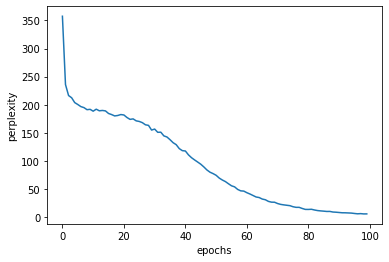

In [13]:
# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 5     # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력(정답 레이블)
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)  # 몫(정수)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 미니배치의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    if epoch % 10 == 0:
        print('| 에폭 %d | 퍼플렉서티 %.2f' % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

### RNNLN Trainer 클래스

In [14]:
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from dataset import ptb
from simple_rnnlm import SimpleRnnlm

| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 416.96
| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 355.15
| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 247.54
| 에폭 4 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 217.85
| 에폭 5 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 208.38
| 에폭 6 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 207.36
| 에폭 7 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 199.82
| 에폭 8 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 200.63
| 에폭 9 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 194.81
| 에폭 10 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 190.75
| 에폭 11 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 193.10
| 에폭 12 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 189.80
| 에폭 13 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 193.52
| 에폭 14 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 187.70
| 에폭 15 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 187.22
| 에폭 16 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 191.24
| 에폭 17 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 189.96
| 에폭 18 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 185.33
| 에폭 19 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 182.40
| 에폭 20 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 182.57
| 에폭 21 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 179.35
| 에폭 22 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 179.

c:\other\study\deep-learning-from-scratch-2\venv\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\other\study\deep-learning-from-scratch-2\venv\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\other\study\deep-learning-from-scratch-2\venv\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\other\study\deep-learning-from-scratch-2\venv\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\other\study\deep-learning-from-scratch-2\venv\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\other\

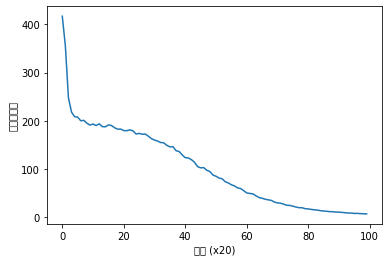

In [15]:
# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 5  # RNN을 펼치는 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000  # 테스트 데이터셋을 작게 설정
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1]  # 입력
ts = corpus[1:]  # 출력（정답 레이블）

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()


# :)